In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning

In [0]:
cardio_data = pd.read_csv('data/cardio_data.csv', sep = ';')
cardio_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [0]:
# changing column names
cardio_data.rename(columns = {'ap_hi': 'blood_pressure_max', 'ap_lo': 'blood_pressure_min', 'cholesterol': 'cholesterol_level', 'gluc': 'glucose_level', 'smoke': 'smoking_status', 'alco': 'alcohol_status', 'active': 'activity_level', 'cardio': 'disease'}, inplace = True)
# casting datatypes
cardio_data['height'] = cardio_data['height'].astype('float')
# converting age from days to years
cardio_data['age'] = cardio_data['age'] // 365
# converting gender into a binary variable
cardio_data['gender'] = cardio_data['gender'] - 1
# calculating bmi
cardio_data['bmi'] = cardio_data['weight'] / (cardio_data['height'] / 100)**2
# dropping height and weight columns
cardio_data.drop(columns = ['height', 'weight'], inplace = True)

In [0]:
# changing sign of negative blood pressure values
cardio_data['blood_pressure_min'] = cardio_data['blood_pressure_min'].map(lambda x: -1 * x if x < 0 else x)
cardio_data['blood_pressure_max'] = cardio_data['blood_pressure_max'].map(lambda x: -1 * x if x < 0 else x)
# calculating blood pressure difference
cardio_data['blood_pressure_diff'] = cardio_data['blood_pressure_max'] - cardio_data['blood_pressure_min']
# dropping rows with diastolic blood pressure > systolic blood pressure
cardio_data = cardio_data.loc[cardio_data['blood_pressure_diff'] > 0]
# dropping rows with unreasonable bmi values
cardio_data = cardio_data.loc[(cardio_data['bmi'] > 10) & (cardio_data['bmi'] < 60)]
# dropping rows with unreasonable blood pressure values
cardio_data = cardio_data.loc[(cardio_data['blood_pressure_max'] > 70) & (cardio_data['blood_pressure_max'] < 200)]
cardio_data = cardio_data.loc[(cardio_data['blood_pressure_min'] > 40) & (cardio_data['blood_pressure_min'] < 160)]
# dropping duplicate values
cardio_data.drop_duplicates(inplace = True)
# dropping id column
cardio_data.drop(columns = ['id'], inplace = True)

In [0]:
cardio_data['disease'].value_counts(normalize = True).round(3)
# very marginal class imbalance -> downsample minority class

0    0.506
1    0.494
Name: disease, dtype: float64

In [0]:
# downsampling minority class
no_disease = cardio_data.loc[cardio_data['disease'] == 0]
disease = cardio_data.loc[cardio_data['disease'] == 1]
no_disease_reduced = no_disease.sample(n = len(disease), random_state = 0)
cardio_data = pd.concat([disease, no_disease_reduced], axis = 0)

In [0]:
cardio_data['disease'].value_counts(normalize = True).round(3)

1    0.5
0    0.5
Name: disease, dtype: float64

In [0]:
cardio_data.to_csv('data/cardio_data_clean.csv')

In [0]:
cardio_data = pd.read_csv('data/cardio_data_clean.csv').drop(columns = ['Unnamed: 0'])
cardio_data.head()

,age,gender,blood_pressure_max,blood_pressure_min,cholesterol_level,glucose_level,smoking_status,alcohol_status,activity_level,disease,bmi,blood_pressure_diff
0,55,0,140,90,3,1,0,0,1,1,34.927679,50
1,51,0,130,70,3,1,0,0,0,1,23.507805,60
2,48,1,150,100,1,1,0,0,1,1,28.710479,50
3,61,1,130,90,3,3,0,0,1,1,29.983588,40
4,45,1,120,80,1,1,0,0,0,1,37.858302,40


# EDA

In [0]:
cardio_data.groupby('gender')['disease'].mean().round(3)

gender
0    0.498
1    0.505
Name: disease, dtype: float64

In [0]:
cardio_data.groupby('alcohol_status')['disease'].mean().round(3)

alcohol_status
0    0.501
1    0.481
Name: disease, dtype: float64

In [0]:
cardio_data.groupby('smoking_status')['disease'].mean().round(3)

smoking_status
0    0.503
1    0.474
Name: disease, dtype: float64

In [0]:
cardio_data.groupby('activity_level')['disease'].mean().round(3)

activity_level
0    0.538
1    0.491
Name: disease, dtype: float64

In [0]:
cardio_data.groupby('cholesterol_level')['disease'].mean().round(3)

cholesterol_level
1    0.441
2    0.601
3    0.766
Name: disease, dtype: float64

In [0]:
cardio_data.groupby('glucose_level')['disease'].mean().round(3)

glucose_level
1    0.481
2    0.592
3    0.622
Name: disease, dtype: float64

In [0]:
min_age, max_age = cardio_data['age'].min(), cardio_data['age'].max()
cardio_data['age_category'] = pd.cut(cardio_data['age'], bins = [min_age,40,45,50,55,60,max_age], labels = ['under 40', '40-45', '45-50', '50-55', '55-60', 'over 60'])
cardio_data.groupby(['age_category'])['disease'].mean().round(3)

age_category
under 40    0.229
40-45       0.349
45-50       0.425
50-55       0.497
55-60       0.573
over 60     0.700
Name: disease, dtype: float64

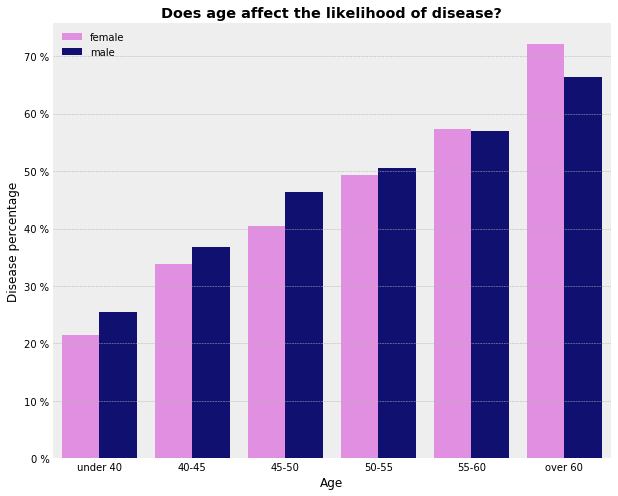

In [0]:
cardio_data['gender_name'] = cardio_data['gender'].map(lambda x: 'male' if x == 1 else 'female')
gender_age_grouped = pd.DataFrame(cardio_data.groupby(['gender_name', 'age_category'])['disease'].mean().round(3)).reset_index()

plt.style.use('bmh')

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
sns.catplot(x = 'age_category', y='disease', hue = 'gender_name', data = gender_age_grouped, kind = 'bar', palette = ['violet', 'navy'], ax = ax)
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.set_yticklabels(['{} %'.format(x) for x in range(0,80,10)])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('Does age affect the likelihood of disease?', fontweight = 'bold')
ax.set_xlabel('Age')
ax.set_ylabel('Disease percentage')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[2:], labels=labels[2:])
ax.legend(frameon=False)
plt.close(2);

In [0]:
min_bmi, max_bmi = cardio_data['bmi'].min(), cardio_data['bmi'].max()
cardio_data['bmi_zone'] = pd.cut(cardio_data['bmi'], bins = [min_bmi,17.5,25,30,max_bmi], labels = ['underweight', 'normal weight', 'overweight', 'obese'])
cardio_data.groupby('bmi_zone')['disease'].mean().round(3)

bmi_zone
underweight      0.271
normal weight    0.402
overweight       0.511
obese            0.629
Name: disease, dtype: float64

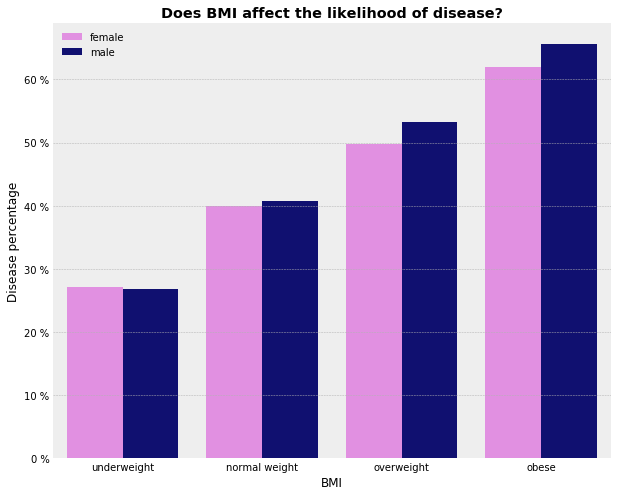

In [0]:
gender_bmi_grouped = pd.DataFrame(cardio_data.groupby(['gender_name', 'bmi_zone'])['disease'].mean().round(3)).reset_index()

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
sns.catplot(x = 'bmi_zone', y='disease', hue = 'gender_name', data = gender_bmi_grouped, kind = 'bar', palette = ['violet', 'navy'], ax = ax)
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.set_yticklabels(['{} %'.format(x) for x in range(0,80,10)])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('Does BMI affect the likelihood of disease?', fontweight = 'bold')
ax.set_xlabel('BMI')
ax.set_ylabel('Disease percentage')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[2:], labels=labels[2:])
ax.legend(frameon=False)
plt.close(2);

In [0]:
min_diastolic_bp, max_diastolic_bp = cardio_data['blood_pressure_min'].min(), cardio_data['blood_pressure_min'].max()
cardio_data['diastolic_zone'] = pd.cut(cardio_data['blood_pressure_min'], bins = [min_diastolic_bp,80,90,120,max_diastolic_bp], labels = ['normal', 'stage 1', 'stage 2', 'stage 3'])
cardio_data.groupby('diastolic_zone')['disease'].mean().round(3)

diastolic_zone
normal     0.390
stage 1    0.745
stage 2    0.837
stage 3    0.875
Name: disease, dtype: float64

In [0]:
min_systolic_bp, max_systolic_bp = cardio_data['blood_pressure_max'].min(), cardio_data['blood_pressure_max'].max()
cardio_data['systolic_zone'] = pd.cut(cardio_data['blood_pressure_max'], bins = [min_systolic_bp,120,140,180,max_systolic_bp], labels = ['normal', 'stage 1', 'stage 2', 'stage 3'])
cardio_data.groupby('systolic_zone')['disease'].mean().round(3)

systolic_zone
normal     0.322
stage 1    0.702
stage 2    0.861
stage 3    0.843
Name: disease, dtype: float64

In [0]:
sub_groups = [('female', 0.498), ('male', 0.505), ('non alcohol drinker', 0.501), ('alcohol drinker', 0.481), ('non active', 0.538), ('active', 0.491), ('normal cholesterol', 0.441), ('high cholesterol', 0.601), ('very high cholesterol', 0.766), ('normal glucose', 0.481), ('high glucose', 0.592), ('very high glucose', 0.622), ('under 40 years', 0.229), ('40-50 years', 0.393), ('50-60 years', 0.534), ('over 60 years', 0.7), ('underweight', 0.271), ('normal weight', 0.402), ('overweight', 0.511), ('obese', 0.629), ('normal dialostic blood pressure', 0.390), ('high dialostic blood pressure (stage 1)', 0.745), ('high dialostic blood pressure (stage 2)', 0.837), ('high dialostic blood pressure (stage 3)', 0.875), ('normal systolic blood pressure', 0.322), ('high systolic blood pressure (stage 1)', 0.702), ('high systolic blood pressure (stage 2)', 0.861), ('high systolic blood pressure (stage 3)', 0.843)]
pd.DataFrame(sub_groups, columns = ['Group', 'Disease proportion']).sort_values(by = 'Disease proportion', ascending = False).reset_index().drop(columns = ['index']).head(12)

,Group,Disease proportion
0,high dialostic blood pressure (stage 3),0.875
1,high systolic blood pressure (stage 2),0.861
2,high systolic blood pressure (stage 3),0.843
3,high dialostic blood pressure (stage 2),0.837
4,very high cholesterol,0.766
5,high dialostic blood pressure (stage 1),0.745
6,high systolic blood pressure (stage 1),0.702
7,over 60 years,0.700
8,obese,0.629
9,very high glucose,0.622


# Data Preprocessing

In [0]:
from sklearn.model_selection import train_test_split

X = cardio_data.drop(columns = ['disease'])
y = cardio_data['disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

X_train.to_csv('data/train_set/cardio_train_predictors.csv')
X_test.to_csv('data/test_set/cardio_test_predictors.csv')
y_train.to_csv('data/train_set/cardio_train_target.csv')
y_test.to_csv('data/test_set/cardio_test_target.csv')

In [0]:
X_train = pd.read_csv('cardio_train_predictors.csv').drop(columns = ['Unnamed: 0'])
X_test = pd.read_csv('cardio_test_predictors.csv').drop(columns = ['Unnamed: 0'])
y_train = pd.read_csv('cardio_train_target.csv', header = None)[1]
y_test = pd.read_csv('cardio_test_target.csv', header = None)[1]

In [0]:
from sklearn.preprocessing import StandardScaler

def pre_processing_pipeline(df, numerical_columns):
    numerical_df = df[numerical_columns]
    categorical_df = df.drop(columns = numerical_columns)

    scaler = StandardScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(numerical_df), columns = numerical_df.columns, index = numerical_df.index)

    processed_df = pd.merge(scaled_df, categorical_df, left_index = True, right_index = True)
    return processed_df

In [0]:
numerical_columns = ['age', 'bmi', 'blood_pressure_max', 'blood_pressure_min', 'blood_pressure_diff', 'cholesterol_level', 'glucose_level']

X_train_processed = pre_processing_pipeline(X_train, numerical_columns)
X_test_processed = pre_processing_pipeline(X_test, numerical_columns)

# Modelling

## Logistic regression

### Training model

In [0]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
base_lr_model = lr.fit(X_train_processed, y_train)

y_test_hat = base_lr_model.predict(X_test_processed)

### Calculating performance metrics

In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

def classification_metrics(y, y_hat):
    accuracy = round(accuracy_score(y, y_hat), 3)
    auc_score = round(roc_auc_score(y, y_hat), 3)
    precision = round(precision_score(y, y_hat), 3)
    recall = round(recall_score(y, y_hat), 3)
    f1_score = round(2 * (precision * recall) / (precision + recall), 3)
    print("(accuracy = {}, auc_score = {})".format(accuracy, auc_score))
    print("")
    print("(precision = {}, recall = {}, f1-score = {})".format(precision, recall, f1_score))
    return None

In [0]:
classification_metrics(y_test, y_test_hat)

(accuracy = 0.731, auc_score = 0.731)

(precision = 0.758, recall = 0.681, f1-score = 0.717)


### Plotting ROC curve

In [0]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fprs, tprs, model_name):
    plt.plot([0,1], [0,1], 'k--', label = "Random")
    plt.plot(fprs, tprs, label = model_name)
    plt.title('ROC curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc = "lower right")
    return plt.show();

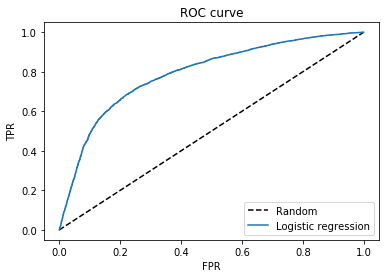

In [0]:
log_odds = base_lr_model.decision_function(X_test_processed)
fprs, tprs, log_odds_thresholds = roc_curve(y_test, log_odds)
plot_roc_curve(fprs, tprs, "Logistic regression")

### Choosing a probability threshold

In [0]:
def log_odds_to_threshold(log_odds):
    threshold = 1/(1 + np.exp(-1 * log_odds))
    return threshold

def optimal_threshold(fprs, tprs, thresholds, log_odds = False):
    distances = []
    for fpr, tpr in zip(fprs,tprs):
        distance = np.sqrt(fpr**2 + (1-tpr)**2)
        distances.append(distance)
    sorted_distances = sorted(enumerate(distances), key = lambda x: x[1])
    best_index = sorted_distances[0][0]
    if log_odds:
      best_threshold = log_odds_to_threshold(thresholds[best_index])
    else:
      best_threshold = thresholds[best_index]
    return print("The best probability threshold is: {}".format(round(best_threshold, 2)))

In [0]:
optimal_threshold(fprs, tprs, log_odds_thresholds, True)

The best probability threshold is: 0.47


### Plotting precision/recall curve with threshold

In [0]:
def precision_recall_curve(model, X, y, thresholds):
    precisions = []
    recalls = []
    for threshold in thresholds:
        y_proba = model.predict_proba(X)[:,1]
        y_pred = np.array(pd.Series(y_proba).map(lambda x: 1 if x > threshold else 0))
        precision, recall = round(precision_score(y, y_pred), 3), round(recall_score(y, y_pred), 3)
        precisions.append(precision)
        recalls.append(recall)
    return precisions, recalls, thresholds

def plot_precision_recall_curve(precisions, recalls, thresholds, best_threshold):
    plt.plot(thresholds, precisions, label = 'Precision')
    plt.plot(thresholds, recalls, label = 'Recall')
    plt.axvline(x = 0.5, ls = ':', color = 'red')
    plt.axvline(x = best_threshold, ls = ':', color = 'green')
    if best_threshold < 0.5:
      plt.text(0.52, 0.2, 'old threshold', color = 'red')
      plt.text(best_threshold - 0.25, 0.2, 'new threshold', color = 'green')
    else:
      plt.text(0.25, 0.2, 'old threshold', color = 'red')
      plt.text(best_threshold + 0.02, 0.2, 'new threshold', color = 'green')
    plt.title('Precision Recall trade-off')
    plt.xlabel('Threshold')
    plt.legend()
    return plt.show();

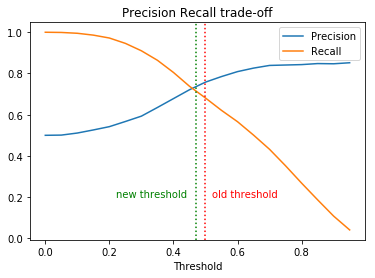

In [0]:
precisions, recalls, thresholds = precision_recall_curve(base_lr_model, X_test_processed, y_test, list(np.arange(0,1, 0.05)))
plot_precision_recall_curve(precisions, recalls, thresholds, 0.47)

### Calculating performance metrics for best threshold

In [0]:
y_proba = base_lr_model.predict_proba(X_test_processed)[:,1]
y_pred = np.array(pd.Series(y_proba).map(lambda x: 1 if x > 0.47 else 0))
classification_metrics(y_test, y_pred)

(accuracy = 0.731, auc_score = 0.731)

(precision = 0.739, recall = 0.715, f1-score = 0.727)


### Plotting confusion matrix for best threshold

In [0]:
def custom_confusion_matrix(y, y_hat):
    confusion_matrix = pd.crosstab(pd.Series(y), pd.Series(y_hat), rownames=['Actual'], colnames=['Predicted'])
    return sns.heatmap(confusion_matrix, annot=True, cmap = ['red', 'green'], cbar = False, fmt = 'g');

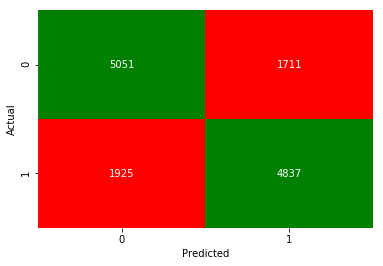

In [0]:
custom_confusion_matrix(y_test, y_pred);

## K-nearest neighbours

### Training baseline model

In [0]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

base_knn_model = knn.fit(X_train_processed, y_train)
y_test_hat = base_knn_model.predict(X_test_processed)

In [12]:
classification_metrics(y_test, y_test_hat)

(accuracy = 0.693, auc_score = 0.693)

(precision = 0.697, recall = 0.682, f1-score = 0.689)


### Hyperparameter tuning

#### Tuning k

In [0]:
from sklearn.model_selection import cross_val_score

ks = range(5,105,5)
scores = []
for k in ks:
    knn = KNeighborsClassifier(n_neighbors = k)
    score = np.mean(cross_val_score(knn, X_train_processed, y_train, scoring = 'roc_auc', cv = 5))
    scores.append(score)

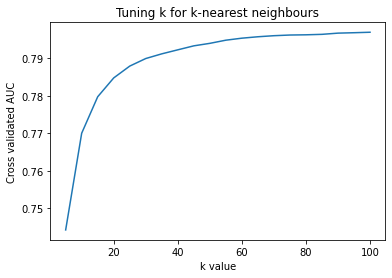

In [14]:
plt.plot(ks, scores)
plt.title('Tuning k for k-nearest neighbours')
plt.xlabel('k value')
plt.ylabel('Cross validated AUC');

#### Tuning weights and distance metric

In [18]:
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [50], 'weights': ['uniform', 'distance'], 'metric': ['manhattan', 'euclidean', 'cosine']}
knn_gs = GridSearchCV(knn, param_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1)
%time knn_gs.fit(X_train_processed, y_train)
knn_gs.best_params_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 1.72 s, sys: 67.1 ms, total: 1.79 s
Wall time: 1min 54s


{'metric': 'euclidean', 'n_neighbors': 50, 'weights': 'uniform'}

### Training tuned model

In [0]:
tuned_knn = KNeighborsClassifier(n_neighbors = 50)

tuned_knn_model = tuned_knn.fit(X_train_processed, y_train)
y_test_hat = tuned_knn_model.predict(X_test_processed)

In [17]:
classification_metrics(y_test, y_test_hat)

(accuracy = 0.734, auc_score = 0.734)

(precision = 0.76, recall = 0.686, f1-score = 0.721)


#### Plotting ROC curve

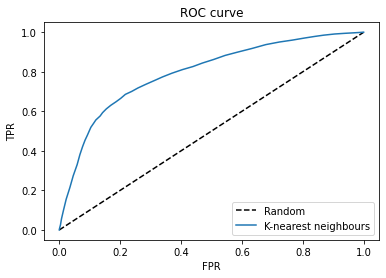

In [27]:
y_proba = tuned_knn.predict_proba(X_test_processed)[:,1]
fprs, tprs, thresholds = roc_curve(y_test, y_proba)
plot_roc_curve(fprs, tprs, "K-nearest neighbours")

#### Choosing a probability threshold

In [31]:
optimal_threshold(fprs, tprs, thresholds)

The best probability threshold is: 0.52


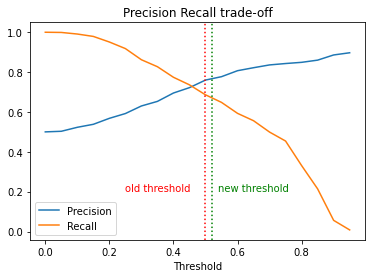

In [34]:
precisions, recalls, thresholds = precision_recall_curve(tuned_knn_model, X_test_processed, y_test, list(np.arange(0,1, 0.05)))
plot_precision_recall_curve(precisions, recalls, thresholds, 0.52)

#### Calculating performance metrics for best threshold

In [35]:
y_pred = np.array(pd.Series(y_proba).map(lambda x: 1 if x > 0.52 else 0))
classification_metrics(y_test, y_pred)

(accuracy = 0.732, auc_score = 0.732)

(precision = 0.767, recall = 0.665, f1-score = 0.712)


#### Plotting confusion matrix for best met

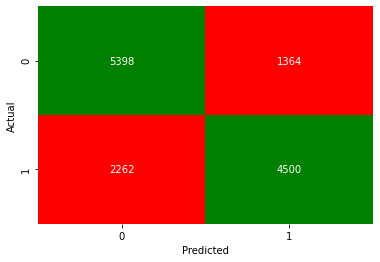

In [36]:
custom_confusion_matrix(y_test, y_pred);